In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from model import AutoEncoder_gnnrnn, AutoEncoder_rnn, AutoEncoder_gnngatrnn
from data import prepare_data_vocab, live_feat, batch_gnn_for_gpu, split_pp_into_sublists, split_train_test, count_occurrences, batch_gnngat_for_gpu
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.optim import lr_scheduler
from utils import save_edge_attr_graph, calculate_variable
import pickle
import matplotlib.pyplot as plt

## Data prepration

In [4]:
word_to_idx, idx_to_word, data, data_emb = prepare_data_vocab("gccData", func=live_feat, function_num=0)

In [ ]:
print("Are you sure? yes/no")
if input()=='yes':
    print('yes')
    with open('data.pickle', 'wb') as f:
        pickle.dump([word_to_idx, idx_to_word, data, data_emb], f)
else:
    print('no')

In [30]:
with open('data.pickle', 'rb') as f:
        [word_to_idx, idx_to_word, data, data_emb] = pickle.load(f)

In [31]:
new_data_emb = []
for g in data_emb:
    num_nodes = len(g[1])
    max_num_token_local = 0
    for gg in g[1]:
        if gg.shape[0]>max_num_token_local:
            max_num_token_local = gg.shape[0]
    if g[0].max() < num_nodes:
        if num_nodes<256 and num_nodes>4:
            if max_num_token_local<300:
                new_data_emb.append(g)
data_emb = new_data_emb

In [ ]:
def hist_plt(data, label):
    plt.hist(data, bins=range(min(data), max(data) + 1), edgecolor='black')  # Adjust bin size if needed
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of '+ label)
    plt.grid(True)
    plt.show()

num_edges = []
num_nodes = []
max_num_token = []
for g in data_emb:
    num_edges.append(g[0].shape[1])
    num_nodes.append(len(g[1]))
    max_num_token_local = 0
    for gg in g[1]:
        if gg.shape[0]>max_num_token_local:
            max_num_token_local = gg.shape[0]
    max_num_token.append(max_num_token_local)

hist_plt(num_edges, '# edges')
hist_plt(num_nodes, '# nodes')
hist_plt(max_num_token, 'max # token')


In [32]:
drop_rate = calculate_variable()
drop_rate = 0

In [33]:
batch_size     = 256

if torch.cuda.is_available():
    device = torch.device("cuda")  # Or "cuda:0" for the first GPU
else:
    device = torch.device("cpu")

dataset = split_pp_into_sublists(data_emb, batch_size)
(train, test) = split_train_test(dataset, drop_rate=drop_rate)
train_gpu = batch_gnn_for_gpu(train, device, len(word_to_idx))
test_gpu = batch_gnn_for_gpu(test, device, len(word_to_idx))
weight = count_occurrences(train, word_to_idx, device)

## GNN LSTM

In [ ]:
#return grad_input.min(), grad_input.min(), grad_input.min()

In [4]:
def register_hooks(model):
    hooks = []
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            hooks.append(layer.register_full_backward_hook(get_gradient))
    return hooks

def get_gradient(module, grad_input, grad_output):
    #print('Gradient Input:', grad_input)  # Gradients with respect to inputs
    #return grad_input
    #print('Gradient Output:', grad_output)  # Gradients with respect to outputs
    global total_gradients, total_parameters, dict_grad
    for name, param in module.named_parameters():
        if param.grad is not None:
            grad = param.grad
            dict_grad[name] = total_gradients
            total_gradients += grad.abs().sum().item()
            total_parameters += grad.numel()


In [30]:
bidir          = True
dir            = 2 if bidir else 1 

num_layers_enc = 2
hidden_dim_enc = 64
num_layers_dec = 2
hidden_dim_dec = 64
emb_dim        = 64
N_max          = len(word_to_idx)+1
layer_dims_gnn = [64]



ae = AutoEncoder_gnnrnn(batch_size     = batch_size,
            bidir          = bidir,
            num_layers_enc = num_layers_enc,
            hidden_dim_enc = hidden_dim_enc,
            num_layers_dec = num_layers_dec,
            hidden_dim_dec = hidden_dim_dec,
            layer_dims_gnn = layer_dims_gnn,
            emb_dim        = emb_dim,
            N_max          = N_max)



#device = torch.device("cpu")
ae.to(device)

criterion      = nn.CrossEntropyLoss(ignore_index=len(word_to_idx), weight=weight)
#criterion_real = nn.CrossEntropyLoss(ignore_index=len(word_to_idx))
#data_emb_device = [(edge_index.to(device), [bb.to(device) for bb in node_embs ]) for (edge_index, node_embs) in data_emb] 
optimizer = optim.Adam(ae.parameters(), lr=0.01)
optimizer = optim.AdamW(ae.parameters(), lr=0.01, weight_decay=0.01)
#optimizer = optim.Adam(ae.parameters(), lr=0.01, weight_decay=0.001)
#hooks = register_hooks(ae)
# Before the training loop
total_gradients = 0.0
total_parameters = 0

#scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) 

#optimizer = optim.SGD(ae.parameters(), lr=0.1, momentum=0.9)
#scheduler = lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

In [22]:
epoch_num = 100
loss_train = []
accu_train = []
loss_test = []
accu_test = []
grad_avg = []
for epoch in range(epoch_num):
    total_loss = 0
    j = 0
    cntBatch = 0
    for (padded_seq, padded_seq_dec, lengths, edge_index) in train_gpu:
        cntBatch += 1
        #print("seq ->", padded_seq.shape)
        #print("lengths -> ", min(lengths), ":", max(lengths))
        out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="teaching", ratio=0.25, ratio_mix=0.8)
        #print(out[:,-1,:])
        loss = criterion(out.flatten(0).reshape(-1,N_max), padded_seq.flatten())
        #print(out.flatten(0).reshape(-1,N_max).argmax(dim=1).to("cpu").tolist())
        #print(padded_seq.flatten().to("cpu").tolist())
        #print("-------------------------------------------------")
        total_loss  += loss.item()
        j += np.sum(lengths)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
    #for hook in hooks:
     #   hook.remove()  # Remove previous hooks
    #hooks = register_hooks(ae)
    #grad_avg.append(total_gradients/total_parameters)
    #print(hooks[0])
    # Optionally, you can print the learning rate to monitor its changes
        #print("Learning Rate:", optimizer.param_groups[0]['lr'])
    if epoch%5==0 or (epoch+1)==epoch_num:
        print(f'For {j} Tokens List in Train set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss/cntBatch:.5f}, Acuuracy: {np.exp(-total_loss/cntBatch)*100:.5f}', end='\n')
        cntBatch_test = 0
        total_loss_test = 0
        j_test = 0
        for (padded_seq, padded_seq_dec, lengths, edge_index) in test_gpu:
            j_test += np.sum(lengths)
            cntBatch_test += 1
            out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="recursive", ratio=1)
            loss = criterion(out.flatten(0).reshape(-1,N_max), padded_seq.flatten())
            total_loss_test  += loss.item()
        loss_test.append(total_loss_test/cntBatch_test)
        accu_test.append(np.exp(-total_loss_test/cntBatch_test)*100)
        print(f'For {j_test} Tokens List in Test set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss_test/cntBatch_test:.5f}, Acuuracy: {np.exp(-total_loss_test/cntBatch_test)*100:.5f}', end='\n')
        print("-----------------------------------------------------------------------------------")
    else:
        print(f'For {j} Tokens List in Train set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss/cntBatch:.5f}, Acuuracy: {np.exp(-total_loss/cntBatch)*100:.5f}', end='\r')
    loss_train.append(total_loss/cntBatch)
    accu_train.append(np.exp(-total_loss/cntBatch)*100)

For 54507 Tokens List in Train set: Epoch 1/100, Average Loss: 2.83269, Acuuracy: 5.88542
For 13216 Tokens List in Test set: Epoch 1/100, Average Loss: 2.64929, Acuuracy: 7.07015
-----------------------------------------------------------------------------------
For 54507 Tokens List in Train set: Epoch 6/100, Average Loss: 2.41458, Acuuracy: 8.94052
For 13216 Tokens List in Test set: Epoch 6/100, Average Loss: 2.60501, Acuuracy: 7.39027
-----------------------------------------------------------------------------------
For 54507 Tokens List in Train set: Epoch 11/100, Average Loss: 2.40969, Acuuracy: 8.98432
For 13216 Tokens List in Test set: Epoch 11/100, Average Loss: 2.58792, Acuuracy: 7.51759
-----------------------------------------------------------------------------------
For 54507 Tokens List in Train set: Epoch 16/100, Average Loss: 2.34280, Acuuracy: 9.605828
For 13216 Tokens List in Test set: Epoch 16/100, Average Loss: 2.64430, Acuuracy: 7.10548
---------------------------

KeyboardInterrupt: 

In [9]:
for hook in hooks:
    hook.remove()

In [46]:
for name, param in ae.named_parameters():
    print(name)
    print(param)
    print("-------------------------------")

enc.weight_ih_l0
Parameter containing:
tensor([[-0.7218,  0.3673,  0.3925,  ..., -0.1274, -0.1911, -0.0575],
        [-0.5486, -0.2140,  0.3919,  ..., -0.0996, -0.2331,  0.3569],
        [ 0.2631,  0.4226,  0.2895,  ..., -0.8137,  0.4365, -0.6244],
        ...,
        [ 0.7515,  0.2327, -0.2643,  ..., -0.1543, -0.0575, -0.4267],
        [ 0.1540, -0.1479, -0.2918,  ...,  0.0502, -0.7872,  0.3232],
        [ 0.7401,  0.2447, -1.1955,  ...,  0.0285,  0.2472, -1.1198]],
       device='cuda:0', requires_grad=True)
-------------------------------
enc.weight_hh_l0
Parameter containing:
tensor([[-0.1510, -0.7207, -0.2121,  ..., -0.4485, -0.2166,  0.1380],
        [ 0.1814,  0.1122, -0.0619,  ...,  0.6065,  0.9286, -0.9765],
        [ 0.0046, -0.2300, -0.2010,  ..., -0.1728,  0.0884, -0.3822],
        ...,
        [-0.5066,  0.6278,  0.0760,  ...,  0.3865,  0.5576,  0.1224],
        [ 0.0628,  0.2472,  0.3245,  ..., -0.3430,  0.3996,  0.4059],
        [-0.1887,  0.2664,  0.1258,  ..., -0.2920

## Performance Visualization

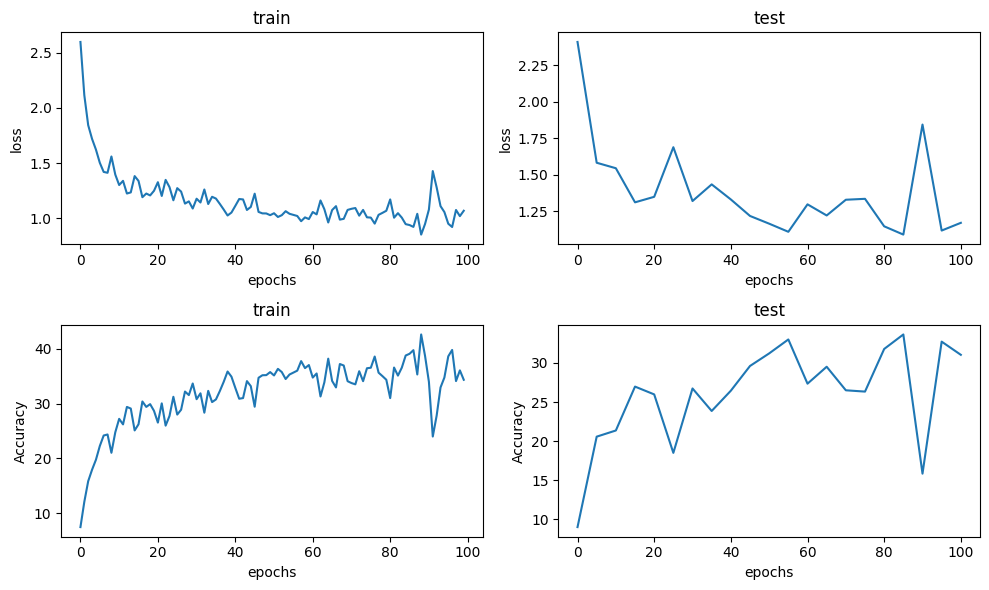

In [35]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10,6)) 
x = [i*5 for i in range(len(accu_test))]
axs[0,0].plot(loss_train)
axs[0,0].set_ylabel("loss")
axs[0,0].set_xlabel("epochs")
axs[0,0].set_title("train")
axs[1,0].plot(accu_train)
axs[1,0].set_ylabel("Accuracy")
axs[1,0].set_xlabel("epochs")
axs[1,0].set_title("train")
axs[0,1].plot(x, loss_test)
axs[0,1].set_ylabel("loss")
axs[0,1].set_xlabel("epochs")
axs[0,1].set_title("test")
axs[1,1].plot(x, accu_test)
axs[1,1].set_ylabel("Accuracy")
axs[1,1].set_xlabel("epochs")
axs[1,1].set_title("test")
plt.tight_layout()
plt.savefig('AE_result_1.png')

In [49]:
d = {'a': 1, 'b':2}
for key, val in d.items():
    print(key, val)

a 1
b 2


In [14]:
for (padded_seq, padded_seq_dec, lengths, edge_index) in test_gpu:
    j_test += np.sum(lengths)
    cntBatch_test += 1
    out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="recursive", ratio=1, ratio_mix=1)
    pred = out.flatten(0).reshape(-1,N_max).argmax(dim=1).to("cpu").tolist()
    actu = padded_seq.flatten().to("cpu").tolist()
    pred_f = []
    actu_f = []
    for i in range(len(actu)):
        if (actu[i]!=40):
            pred_f.append(pred[i])
            actu_f.append(actu[i])
    print("pred:", *pred_f, sep='\t')
    print("actu:", *actu_f, sep='\t')
    print("----------------------------------------------------------------------------------------")
    break
for (padded_seq, padded_seq_dec, lengths, edge_index) in test_gpu:
    j_test += np.sum(lengths)
    cntBatch_test += 1
    out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="recursive", ratio=0, ratio_mix=0)
    pred = out.flatten(0).reshape(-1,N_max).argmax(dim=1).to("cpu").tolist()
    actu = padded_seq.flatten().to("cpu").tolist()
    pred_f = []
    actu_f = []
    for i in range(len(actu)):
        if (actu[i]!=40):
            pred_f.append(pred[i])
            actu_f.append(actu[i])
    print("pred:", *pred_f, sep='\t')
    print("actu:", *actu_f, sep='\t')
    print("----------------------------------------------------------------------------------------")
    break

pred:	8	28	25	23	8	8	8	28	25	23	8	28	25	23	8	28	8	8	8	8	8	8	28	25	23	8	8	8	28	25	23	8	8	8	28	25	9	8	32	9	11	14	15	16	8	28	25	23	8	8	8	8	8	14	8	37	8	8	8	8	8	8	28	25	23	8	8	8	8	8	8	8	8	8	36	25	25	4	25	8	36	8	37	8	36	25	25	3	23	8	8	8	37	8	37	8	8	8	8	8	8	32	9	11	14	15	16	8	36	25	25	3	23	8	8	8	37	8	8	8	8	8	8	28	25	23	8	8	8	8	8	8	8	8	36	25	25	4	23	8	32	9	11	14	15	16	17	18	25	4	25	8	32	9	11	14	15	16	17	18	19	4	8	36	25	25	2	25	8	36	25	25	4	25	8	28	25	24	8	28	25	8	8	8	8	8	28	24	24	25	8	28	25	24	8	28	25	24	8	28	25	24	8	28	25	24	8	28	25	24	8	28	25	24	8	28	24	24	24	24	8	8	36	25	25	2	23	8	36	25	25	2	23	8	8	35	25	30	22	8	36	25	25	2	23	8	36	25	25	3	23	8	36	25	25	3	23	8	36	8	37	8	37	8	8	8	8	8	8	8	8	36	25	25	2	23	8	32	9	11	14	15	8	28	25	23	8	8	8	8	8	28	24	25	8	28	25	24	8	28	25	24	8	28	25	24	8	28	25	24	8	8	8	8	8	8	8	8	8	8	8	8	32	9	11	14	15	16	8	28	25	23	8	8	8	8	8	8	8	8	8	8	8	32	9	11	14	15	16	8	28	25	23	8	8	8	8	8	8	8	8	8	8	32	9	11	14	15	16	17	18	19	8	8	8	8	32	9	11	14	15	16	17	18	25	25	23	8	9	11	25	8	28	2

In [39]:
for (padded_seq, padded_seq_dec, lengths, edge_index) in train_gpu:
    j_test += np.sum(lengths)
    cntBatch_test += 1
    out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="recursive")
    print("pred:", out.flatten(0).reshape(-1,N_max).argmax(dim=1).to("cpu").tolist())
    print("actu:",padded_seq.flatten().to("cpu").tolist())
    print("----------------------------------------------------------------------------------------")

'2.2.2+cu118'

## LSTM Only

In [33]:
bidir          = True
dir            = 2 if bidir else 1 
num_layers_enc = 2
hidden_dim_enc = 64
num_layers_dec = 2
hidden_dim_dec = 64
emb_dim        = 64
N_max          = len(word_to_idx)+1


ae = AutoEncoder_rnn(batch_size     = batch_size,
            bidir          = True,
            num_layers_enc = num_layers_enc,
            hidden_dim_enc = hidden_dim_enc,
            num_layers_dec = num_layers_dec,
            hidden_dim_dec = hidden_dim_dec,
            emb_dim        = emb_dim,
            N_max          = N_max)

#device = torch.device("cpu")
ae.to(device)


criterion = nn.CrossEntropyLoss(ignore_index=len(word_to_idx), weight=weight)
#data_emb_device = [(edge_index.to(device), [bb.to(device) for bb in node_embs ]) for (edge_index, node_embs) in data_emb] 

optimizer = optim.Adam(ae.parameters(), lr=0.01, weight_decay=0.001)
#optimizer = optim.Adam(ae.parameters(), lr=0.01)

In [34]:
epoch_num = 100
loss_train = []
accu_train = []
loss_test = []
accu_test = []
for epoch in range(epoch_num):
    total_loss = 0
    j = 0
    cntBatch = 0
    for (padded_seq, padded_seq_dec, lengths, edge_index) in train_gpu:
        cntBatch += 1
        #print("seq ->", padded_seq.shape)
        #print("lengths -> ", min(lengths), ":", max(lengths))
        out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="teaching", ratio=0.25, ratio_mix=0.8)
        #print(out[:,-1,:])
        loss = criterion(out.flatten(0).reshape(-1,N_max), padded_seq.flatten())
        #print(out.flatten(0).reshape(-1,N_max).argmax(dim=1).to("cpu").tolist())
        #print(padded_seq.flatten().to("cpu").tolist())
        #print("-------------------------------------------------")
        total_loss  += loss.item()
        j += np.sum(lengths)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch%5==0 or (epoch+1)==epoch_num:
        print(f'For {j} Tokens List in Train set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss/cntBatch:.5f}, Acuuracy: {np.exp(-total_loss/cntBatch)*100:.5f}', end='\n')
        cntBatch_test = 0
        total_loss_test = 0
        j_test = 0
        for (padded_seq, padded_seq_dec, lengths, edge_index) in test_gpu:
            j_test += np.sum(lengths)
            cntBatch_test += 1
            out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="recursive", ratio=1)
            loss = criterion(out.flatten(0).reshape(-1,N_max), padded_seq.flatten())
            total_loss_test  += loss.item()
        loss_test.append(total_loss_test/cntBatch_test)
        accu_test.append(np.exp(-total_loss_test/cntBatch_test)*100)
        print(f'For {j_test} Tokens List in Test set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss_test/cntBatch_test:.5f}, Acuuracy: {np.exp(-total_loss_test/cntBatch_test)*100:.5f}', end='\n')
        print("-----------------------------------------------------------------------------------")
    else:
        print(f'For {j} Tokens List in Train set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss/cntBatch:.5f}, Acuuracy: {np.exp(-total_loss/cntBatch)*100:.5f}', end='\r')
    loss_train.append(total_loss/cntBatch)
    accu_train.append(np.exp(-total_loss/cntBatch)*100)

For 50878 Tokens List in Train set: Epoch 1/100, Average Loss: 2.59627, Acuuracy: 7.45515
For 16845 Tokens List in Test set: Epoch 1/100, Average Loss: 2.40912, Acuuracy: 8.98945
-----------------------------------------------------------------------------------
For 50878 Tokens List in Train set: Epoch 6/100, Average Loss: 1.50313, Acuuracy: 22.24330
For 16845 Tokens List in Test set: Epoch 6/100, Average Loss: 1.58158, Acuuracy: 20.56495
-----------------------------------------------------------------------------------
For 50878 Tokens List in Train set: Epoch 11/100, Average Loss: 1.30184, Acuuracy: 27.20299
For 16845 Tokens List in Test set: Epoch 11/100, Average Loss: 1.54396, Acuuracy: 21.35328
-----------------------------------------------------------------------------------
For 50878 Tokens List in Train set: Epoch 16/100, Average Loss: 1.33898, Acuuracy: 26.21122
For 16845 Tokens List in Test set: Epoch 16/100, Average Loss: 1.31035, Acuuracy: 26.97261
----------------------

## GAT

In [34]:

bidir          = False
dir            = 2 if bidir else 1 
num_layers_enc = 2
hidden_dim_enc = 64
num_layers_dec = 2
hidden_dim_dec = 64
num_layers_gnn = 16
emb_dim        = 8
N_max          = len(word_to_idx)+1


ae = AutoEncoder_gnngatrnn(batch_size     = batch_size,
            bidir          = True,
            num_layers_enc = num_layers_enc,
            hidden_dim_enc = hidden_dim_enc,
            num_layers_dec = num_layers_dec,
            hidden_dim_dec = hidden_dim_dec,
            num_layers_gnn = num_layers_gnn,
            emb_dim        = emb_dim,
            N_max          = N_max)

#device = torch.device("cpu")
ae.to(device)


criterion = nn.CrossEntropyLoss(ignore_index=len(word_to_idx), weight=weight)
#data_emb_device = [(edge_index.to(device), [bb.to(device) for bb in node_embs ]) for (edge_index, node_embs) in data_emb] 

#optimizer = optim.Adam(ae.parameters(), lr=0.01, weight_decay=0.001)
optimizer = optim.Adam(ae.parameters(), lr=0.01)
optimizer = optim.AdamW(ae.parameters(), lr=0.001, weight_decay=0.01)

In [35]:
epoch_num = 100
loss_train = []
accu_train = []
loss_test = []
accu_test = []
for epoch in range(epoch_num):
    total_loss = 0
    j = 0
    cntBatch = 0
    for (padded_seq, padded_seq_dec, lengths, edge_index) in train_gpu:
        cntBatch += 1
        #print("seq ->", padded_seq.shape)
        #print("lengths -> ", min(lengths), ":", max(lengths))
        out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="teaching", ratio=0.25, ratio_mix=0.8)
        #print(out[:,-1,:])
        loss = criterion(out.flatten(0).reshape(-1,N_max), padded_seq.flatten())
        #print(out.flatten(0).reshape(-1,N_max).argmax(dim=1).to("cpu").tolist())
        #print(padded_seq.flatten().to("cpu").tolist())
        #print("-------------------------------------------------")
        total_loss  += loss.item()
        j += np.sum(lengths)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch%5==0 or (epoch+1)==epoch_num:
        print(f'For {j} Tokens List in Train set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss/cntBatch:.5f}, Acuuracy: {np.exp(-total_loss/cntBatch)*100:.5f}', end='\n')
        cntBatch_test = 0
        total_loss_test = 0
        j_test = 0
        for (padded_seq, padded_seq_dec, lengths, edge_index) in test_gpu:
            j_test += np.sum(lengths)
            cntBatch_test += 1
            out = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="recursive", ratio=1)
            loss = criterion(out.flatten(0).reshape(-1,N_max), padded_seq.flatten())
            total_loss_test  += loss.item()
        loss_test.append(total_loss_test/cntBatch_test)
        accu_test.append(np.exp(-total_loss_test/cntBatch_test)*100)
        print(f'For {j_test} Tokens List in Test set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss_test/cntBatch_test:.5f}, Acuuracy: {np.exp(-total_loss_test/cntBatch_test)*100:.5f}', end='\n')
        print("-----------------------------------------------------------------------------------")
    else:
        print(f'For {j} Tokens List in Train set: Epoch {epoch+1}/{epoch_num}, Average Loss: {total_loss/cntBatch:.5f}, Acuuracy: {np.exp(-total_loss/cntBatch)*100:.5f}', end='\r')
    loss_train.append(total_loss/cntBatch)
    accu_train.append(np.exp(-total_loss/cntBatch)*100)

For 1043216 Tokens List in Train set: Epoch 1/100, Average Loss: 3.51706, Acuuracy: 2.96865
For 261758 Tokens List in Test set: Epoch 1/100, Average Loss: 3.26159, Acuuracy: 3.83275
-----------------------------------------------------------------------------------
For 1043216 Tokens List in Train set: Epoch 6/100, Average Loss: 2.16485, Acuuracy: 11.47673
For 261758 Tokens List in Test set: Epoch 6/100, Average Loss: 2.36327, Acuuracy: 9.41120
-----------------------------------------------------------------------------------


KeyboardInterrupt: 

In [27]:
print("Are you sure? yes/no")
if input()=='yes':
    print('yes')
    with open('ae_gat.pickle', 'wb') as f:
        pickle.dump(ae, f)
else:
    print('no')

Are you sure? yes/no


yes


PicklingError: Can't pickle <class 'model.AutoEncoder_gnngatrnn'>: it's not the same object as model.AutoEncoder_gnngatrnn

In [16]:
batch_cnt = -1
for (padded_seq, padded_seq_dec, lengths, edge_index) in test_gpu:
        batch_cnt+=1
        out, (edge_index_gat, alpha_gat) = ae(padded_seq, padded_seq_dec, lengths, edge_index, mode="recursive", ratio=0.25, ratio_mix=0.8, return_attention_weights=True)
        save_edge_attr_graph(edge_index_gat, alpha_gat, batch_cnt)
        if batch_cnt>1:
                break

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

# Example edge index
edge_index = [(0, 1), (1, 2), (2, 3), (3, 0)]
# Example edge attributes
edge_attrs = [1, 2, 3, 4]  # Just random attributes for demonstration
filename = 'Edge_alpha/edge.png'
save_graph(edge_index, edge_attrs, filename)
# Create a graph
def save_graph(edge_index, edge_attrs, filename):
    G = nx.Graph()

    # Add edges with attributes
    for i, (src, dst) in enumerate(edge_index):
        G.add_edge(src, dst, weight=edge_attrs[i])

    # Visualization
    pos = nx.spring_layout(G)  # Layout for visualization
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=10, font_weight='bold')

    # Adding edge labels
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    plt.savefig()


NameError: name 'save_graph' is not defined

In [52]:
import networkx as nx

def get_disconnected_subgraphs(edge_index):
    # Create a graph from the edge index
    G = nx.Graph()
    G.add_edges_from(edge_index)

    # Get the disconnected subgraphs
    disconnected_subgraphs = list(nx.connected_components(G))
    print(disconnected_subgraphs)

    # Convert each subgraph to edge indices
    disconnected_edge_indices = []
    for subgraph_nodes in disconnected_subgraphs:
        subgraph = G.subgraph(subgraph_nodes)
        subgraph_edge_index = list(subgraph.edges())
        disconnected_edge_indices.append(subgraph_edge_index)

    return disconnected_edge_indices

# Example usage:
edge_index = [(0, 1), (1, 2), (2, 3), (4, 5), (5, 6)]
disconnected_subgraphs = get_disconnected_subgraphs(edge_index)
print(disconnected_subgraphs)


[{0, 1, 2, 3}, {4, 5, 6}]
[[(0, 1), (1, 2), (2, 3)], [(4, 5), (5, 6)]]


In [81]:
with torch.no_Grad():
    model(x)
model.eval()
with torch.no_grad():
    model(x)

TypeError: Linear.forward() missing 1 required positional argument: 'x'

In [80]:
for name, param in ae.named_parameters():
    if 'gnn2' in name:
        print(name)
        print(param.shape)
        print("min", param.min())
        print("max", param.max())
        print(param)
        print("-------------------------------")

gnn2.att_src
torch.Size([1, 1, 256])
min tensor(-0.8647, device='cuda:0', grad_fn=<MinBackward1>)
max tensor(0.9604, device='cuda:0', grad_fn=<MaxBackward1>)
Parameter containing:
tensor([[[ 0.0380, -0.6224, -0.3401, -0.0409,  0.2148, -0.0699, -0.0282,
          -0.2588, -0.3933, -0.2451, -0.0504, -0.1446,  0.5270, -0.1163,
           0.3794,  0.4475, -0.1785,  0.0813,  0.8437,  0.6428, -0.4473,
           0.4335,  0.7778, -0.1382, -0.0149, -0.0450, -0.1412,  0.2145,
          -0.2329,  0.2704,  0.4642,  0.3545, -0.3245, -0.5189,  0.2327,
           0.0099,  0.1821,  0.1375,  0.4034,  0.0968,  0.1682,  0.4240,
           0.0655, -0.0078, -0.0556,  0.3160,  0.3039, -0.2118,  0.4743,
           0.1550,  0.2273,  0.4690, -0.1279,  0.5365, -0.0078, -0.1361,
           0.4644,  0.5937,  0.0484,  0.2602,  0.5636, -0.1079, -0.0307,
           0.2517, -0.1038, -0.3210, -0.2267, -0.4912,  0.1787,  0.7502,
          -0.2820,  0.0038, -0.2124, -0.0328,  0.2463,  0.0312,  0.3132,
           0.1073

In [82]:
from torch_geometric.nn import GATConv

In [88]:
a = GATConv(in_channels=3, out_channels=3)

In [92]:
in_channels=3
isinstance(in_channels, int)

True

In [94]:
import inspect
inspect.getfile(GATConv)

'/home/reza/.local/lib/python3.10/site-packages/torch_geometric/nn/conv/gat_conv.py'